In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans

src = cv2.imread('smarties.png')

In [2]:
def step1(src):
    gray = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)
    gray = cv2.medianBlur(gray, 5)
    
    rows = gray.shape[0]
    circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, 1, rows / 8,
                               param1 = 100, param2 = 30,
                               minRadius = 1, maxRadius = 30)
    circles = np.uint16(np.around(circles))

    # trabalhando com o objeto 'circles' (contém: coordenadas x, y e raio)

    src = cv2.imread('smarties.png') # lendo a imagem novamente, para obter as cores (acessando coordenadas)
    src = cv2.cvtColor(src, cv2.COLOR_BGR2RGB)

    info = [[i[2]] for i in circles[0]] # base(dados que serão utilizados em dataframe)

    coords_aux = [[i[0], i[1]] for i in circles[0]] # aux
    scls_aux = [src[i[1]][i[0]].tolist() for i in coords_aux] # aux
                        # passaremos estesa valores no kmeans, este nos retonará os clusters de cada tupla rgb, 
                        # 'apendaremos' o retorno na lista de listas 'info'
    for n in range(len(info)):
        for t in coords_aux[n]:
            info[n].append(t)
        for i in scls_aux[n]:
            info[n].append(i)
            
    return info, scls_aux

# buscando pelo melhor número de clusters para um kmeans, que indentificará quantas cores de doces existem
def step2(scls_aux):
    X = pd.DataFrame(scls_aux)
    distortions = []
    K = range(1,10)
    for k in K:
        kmns = KMeans(n_clusters = k, random_state = 123)
        kmns.fit(X)
        distortions.append(kmns.inertia_)
    plt.figure(figsize = (6, 4))   
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.show()
    
# ajustando kmeans para o número ideal de clusters, de acordo com o elbow plot
def step3(scls_aux, optimal_k):
    X = pd.DataFrame(scls_aux)

    kmns = KMeans(n_clusters = optimal_k, random_state = 123)
    kmns.fit(X)
    fig = plt.figure(figsize = (6, 4))
    ax = Axes3D(fig, rect = [0, 0, .95, 1], elev = 48, azim = 134)
    labels = kmns.labels_
    ax.scatter(X[0], X[1], X[2], c = labels.astype(np.float), edgecolor = 'k')
    plt.show()
    
def step4(scls_aux, info, optimal_k):
    X = pd.DataFrame(scls_aux)
    kmns = KMeans(n_clusters = optimal_k, random_state = 123)
    kmns.fit(X)
    clusters = kmns.predict(scls_aux).tolist()
    # juntar 'clusters' a 'info', então 'info' estará pronta para ser transformada em um dataframe
    for n in range(len(info)):
        info[n].append(clusters[n])
    df = pd.DataFrame(info, columns = ['radius', 'x', 'y','r', 'g', 'b', 'cluster'])
    
    return df

def step5(df):
    # estabelecendo uma tupla rgb para cada cluster (tirando as medianas de cada canal, para cada cluster)
    df_color_tuples = df.groupby('cluster').median()[['r', 'g', 'b']]
    df_color_tuples = df_color_tuples.apply(lambda x: round(x)).astype(int)
    return df_color_tuples

# aplicando labels aos clusters
def label_clusters(x, labels):
    for n in labels:
        if x == n:
            return labels[n]
def step6(df):
    df['cluster_label'] = df['cluster'].apply(lambda x: label_clusters(x, labels))
    df.drop(columns = ['r', 'g', 'b', 'cluster'], inplace = True)
    return df
# reler imagem e converter para rgb antes de passar aqui

def step7(df, src):
    txt = 0
    for n in range(len(df)):

        center = (df['x'].iloc[n], df['y'].iloc[n])

        cv2.circle(src, center, 1, (0, 100, 100), 3)
        radius = df['radius'].iloc[n]
        cv2.circle(src, center, radius, (255, 0, 255), 3)
        cv2.putText(src, str(txt), center, cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 3)
        txt += 1
    plt.imshow(src)
    plt.show()

    df.drop(columns = ['x', 'y'], inplace = True)
    df['radius'] = df['radius'].apply(lambda x: np.pi*(x**2))
    df = df.rename(columns = {'radius':'area'})
    print(df[['cluster_label', 'area']])
    return df

def step8(df):
    print('--------------------------')
    print('ESTATÍSTICAS GERAIS')
    print('')
    print(df['area'].agg(['mean', 'std', 'count']))
    print('--------------------------')
    print('ESTATÍSTICAS POR COR')
    df_final = df.groupby('cluster_label').agg({'area':['mean', 'std', 'count']})
    print(df_final)

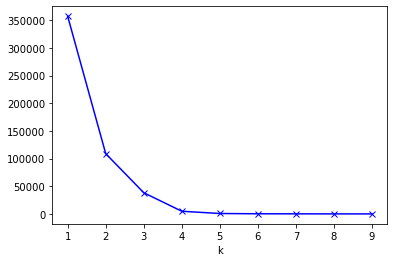

In [3]:
info, scls_aux = step1(src)
step2(scls_aux)

# identificando número ideal de clusters (4)

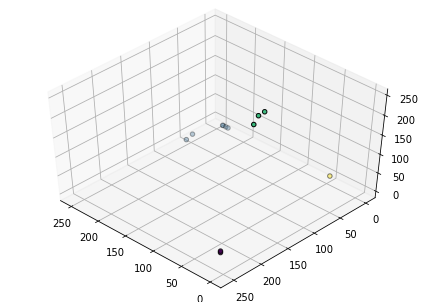

In [4]:
# step facultativo (visual)
step3(scls_aux, 4)

In [5]:
df = step4(scls_aux, info, 4)
df_colors = step5(df)

In [6]:
# uma tupla rgb representando cada cluster

df_colors

,r,g,b
cluster,,,
0,0,255,50
1,238,0,0
2,62,124,247
3,43,3,11


In [7]:
# buscando por cores para estas tuplas:

# busca manual em: 'https://www.rapidtables.com/web/color/RGB_Color.html'
# a busca traz um 'nome' para cada cor, com base em uma tupla

# verde (0, 255, 50) <- cluster 0
# vermelho (238, 0, 0) <- cluster 1
# azul (62, 124, 247) <- cluster 2
# marrom_escuro (43, 3, 11) <- cluster 3 

labels = {0 : 'verde', 1 : 'vermelho', 2 : 'azul', 3 : 'marrom_escuro'}

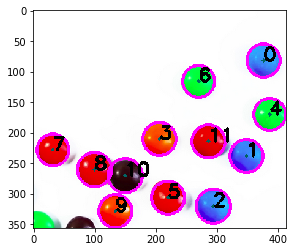

    cluster_label         area
0            azul  2290.221044
1            azul  2290.221044
2            azul  2463.008640
3        vermelho  2290.221044
4           verde  2123.716634
5        vermelho  2290.221044
6           verde  2123.716634
7        vermelho  2123.716634
8        vermelho  2463.008640
9        vermelho  2290.221044
10  marrom_escuro  2463.008640
11       vermelho  2290.221044
--------------------------
ESTATÍSTICAS GERAIS

mean     2291.791841
std       125.302618
count      12.000000
Name: area, dtype: float64
--------------------------
ESTATÍSTICAS POR COR
                      area                  
                      mean         std count
cluster_label                               
azul           2347.816910   99.758965     3
marrom_escuro  2463.008640         NaN     1
verde          2123.716634    0.000000     2
vermelho       2291.268242  107.305817     6


In [8]:
df = step6(df)
src = cv2.imread('smarties.png')
src = cv2.cvtColor(src, cv2.COLOR_BGR2RGB)
df = step7(df, src)
step8(df)

# imagem 'legendada' por cor e área